In [1]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random, numpy as np
random.seed(42)
np.random.seed(42)

In [2]:
import pandas as pd


df = pd.read_excel('../data/demand_prediction_weekly.xlsx')  # <-- change path if needed

In [3]:
medicine_name = 'MONTEMAC FX TAB'
df_med = df[df['Product_Name'] == medicine_name].copy()

# Sort by week
#df_med = df_med.sort_values('Week')
df = df.sort_values('Week').reset_index(drop=True)


In [4]:
print(df_med.head())

        Product_Name      Week  Year  Week_Number  Total_Quantity
804  MONTEMAC FX TAB  2022-W01  2022            1               0
805  MONTEMAC FX TAB  2022-W02  2022            2               0
806  MONTEMAC FX TAB  2022-W03  2022            3               0
807  MONTEMAC FX TAB  2022-W04  2022            4               0
808  MONTEMAC FX TAB  2022-W05  2022            5               0


In [5]:

# ---- Derive Approximate Month ----
# Since there are ~4.3 weeks per month, convert week number to month roughly
df_med['Month'] = np.ceil(df_med['Week_Number'] / 4.33).astype(int)
df_med['Month'] = df_med['Month'].clip(upper=12)


# ---- Derive Quarter ----
df_med['Quarter'] = ((df_med['Month'] - 1) // 3 + 1).astype(int)

# ---- Flags for Year Start/End ----
df_med['Is_Year_Start'] = (df_med['Week_Number'] <= 4).astype(int)
df_med['Is_Year_End'] = (df_med['Week_Number'] >= 48).astype(int)

df_med['Sin_Week'] = np.sin(2 * np.pi * df_med['Week_Number'] / 52)
df_med['Cos_Week'] = np.cos(2 * np.pi * df_med['Week_Number'] / 52)


In [6]:
print(df_med)

         Product_Name      Week  Year  Week_Number  Total_Quantity  Month  \
804   MONTEMAC FX TAB  2022-W01  2022            1               0      1   
805   MONTEMAC FX TAB  2022-W02  2022            2               0      1   
806   MONTEMAC FX TAB  2022-W03  2022            3               0      1   
807   MONTEMAC FX TAB  2022-W04  2022            4               0      1   
808   MONTEMAC FX TAB  2022-W05  2022            5               0      2   
...               ...       ...   ...          ...             ...    ...   
1000  MONTEMAC FX TAB  2025-W38  2025           38              30      9   
1001  MONTEMAC FX TAB  2025-W39  2025           39              15     10   
1002  MONTEMAC FX TAB  2025-W40  2025           40              14     10   
1003  MONTEMAC FX TAB  2025-W41  2025           41              66     10   
1004  MONTEMAC FX TAB  2025-W42  2025           42              24     10   

      Quarter  Is_Year_Start  Is_Year_End  Sin_Week      Cos_Week  
804    

In [7]:
for lag in range(1, 13):  # 12 weeks (3 months)
    df_med[f'lag_{lag}'] = df_med['Total_Quantity'].shift(lag)

df_med['rolling_mean_3'] = df_med['Total_Quantity'].shift(1).rolling(window=3).mean()
df_med['rolling_mean_5'] = df_med['Total_Quantity'].shift(1).rolling(window=5).mean()



df_med['rolling_mean_6'] = df_med['Total_Quantity'].shift(1).rolling(6).mean()
df_med['rolling_std_6'] = df_med['Total_Quantity'].shift(1).rolling(6).std()


df_med['rolling_mean_8'] = df_med['Total_Quantity'].shift(1).rolling(window=8).mean()
df_med['rolling_std_4'] = df_med['Total_Quantity'].shift(1).rolling(window=4).std()

df_med = df_med.dropna()


In [8]:
print(df_med.head())

        Product_Name      Week  Year  Week_Number  Total_Quantity  Month  \
816  MONTEMAC FX TAB  2022-W13  2022           13               0      4   
817  MONTEMAC FX TAB  2022-W14  2022           14               0      4   
818  MONTEMAC FX TAB  2022-W15  2022           15               0      4   
819  MONTEMAC FX TAB  2022-W16  2022           16               0      4   
820  MONTEMAC FX TAB  2022-W17  2022           17               0      4   

     Quarter  Is_Year_Start  Is_Year_End  Sin_Week  ...  lag_9  lag_10  \
816        2              0            0  1.000000  ...    0.0     0.0   
817        2              0            0  0.992709  ...    0.0     0.0   
818        2              0            0  0.970942  ...    0.0     0.0   
819        2              0            0  0.935016  ...    0.0     0.0   
820        2              0            0  0.885456  ...    0.0     0.0   

     lag_11  lag_12  rolling_mean_3  rolling_mean_5  rolling_mean_6  \
816     0.0     0.0        

In [9]:
from pickle import TRUE

from sympy import false


X_med = df_med.drop(columns=['Total_Quantity', 'Week', 'Product_Name'])
y_med = df_med['Total_Quantity']

# Drop non-numeric columns if any
#X_med = X_med.apply(pd.to_numeric, errors='ignore')
#non_numeric_cols = X_med.select_dtypes(include=['object']).columns
#if len(non_numeric_cols) > 0:
#    X_med = X_med.drop(columns=non_numeric_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X_med, y_med, test_size=0.2, shuffle=False
)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
a = X_train
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
print(X_train)
print(y_train)

[[-1.34308841 -0.99420917 -0.85936753 ... -0.5124664  -0.48634167
  -0.49406938]
 [-1.34308841 -0.92784065 -0.85936753 ... -0.5124664  -0.48634167
  -0.49406938]
 [-1.34308841 -0.86147213 -0.85936753 ... -0.5124664  -0.48634167
  -0.49406938]
 ...
 [ 2.21491774 -1.72426285 -1.73027019 ...  1.68943261  1.81835156
   1.60328707]
 [ 2.21491774 -1.65789433 -1.73027019 ...  1.5992754   1.63821462
   0.612368  ]
 [ 2.21491774 -1.59152582 -1.73027019 ...  1.3246405   1.11899637
   0.81222143]]
816     0
817     0
818     0
819     0
820     0
       ..
962     0
963    24
964     5
965    38
966    87
Name: Total_Quantity, Length: 151, dtype: int64


In [12]:
from xgboost import XGBRegressor

"""

| Parameter        | Meaning           | Effect                  | Typical Range |
| ---------------- | ----------------- | ----------------------- | ------------- |
| n_estimators     | number of trees   | More trees = better fit | 300–1000      |
| learning_rate    | Step size         | Lower = more stable     | 0.01–0.1      |
| max_depth        | Tree depth        | Higher = more complex   | 3–10          |
| subsample        | Row sampling      | Prevents overfitting    | 0.5–1.0       |
| colsample_bytree | Column sampling   | Prevents overfitting    | 0.6–1.0       |
| min_child_weight | Min data per leaf | Higher = simpler        | 1–10          |
| gamma            | Split threshold   | Higher = conservative   | 0–1           |
| reg_lambda       | L2 regularization | Higher = less overfit   | 0.1–10        |

"""

model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
    random_state=42
)



model.fit(X_train, y_train)
y_pred = model.predict(X_test)

shift_weeks = 2  # number of weeks to shift

# Align predictions and actuals
aligned_y_pred = y_pred[shift_weeks:]      # drop first 'shift_weeks' predictions
aligned_y_test = y_test[:-shift_weeks]     # drop last 'shift_weeks' actuals

# Compute metrics
mae = mean_absolute_error(aligned_y_test, aligned_y_pred)
rmse = np.sqrt(mean_squared_error(aligned_y_test, aligned_y_pred))
r2 = r2_score(aligned_y_test, aligned_y_pred)

print(f"MAE (aligned): {mae:.2f}")
print(f"RMSE (aligned): {rmse:.2f}")
print(f"R² (aligned): {r2:.2f}")



MAE (aligned): 16.82
RMSE (aligned): 21.08
R² (aligned): 0.29


In [13]:
"""

model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
)
MAE (aligned): 11.70
RMSE (aligned): 15.51
R² (aligned): 0.54




model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
)


model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.5,
)


{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=1.0,
    random_state=42
)

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    random_state=42,
    reg_lambda=2.0,
    reg_alpha=0.5
)

"""

'\n\nmodel = XGBRegressor(\n    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes\n    n_estimators=500,\n    learning_rate=0.01,\n    max_depth=4,\n    subsample=1,\n    colsample_bytree=1,\n    min_child_weight=1,\n    gamma=0.1,\n    reg_lambda=1.0,\n)\nMAE (aligned): 11.70\nRMSE (aligned): 15.51\nR² (aligned): 0.54\n\n\n\n\nmodel = XGBRegressor(\n    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes\n    n_estimators=500,\n    learning_rate=0.01,\n    max_depth=4,\n    subsample=0.9,\n    colsample_bytree=0.9,\n    min_child_weight=1,\n    gamma=0.1,\n    reg_lambda=1.0,\n)\n\n\nmodel = XGBRegressor(\n    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes\n    n_estimators=500,\n    learning_rate=0.01,\n    max_depth=4,\n    subsample=0.9,\n    colsample_bytree=0.9,\n    min_child_weight=1,\n    gamma=0.1,\n    reg_lambda=1.5,\n)

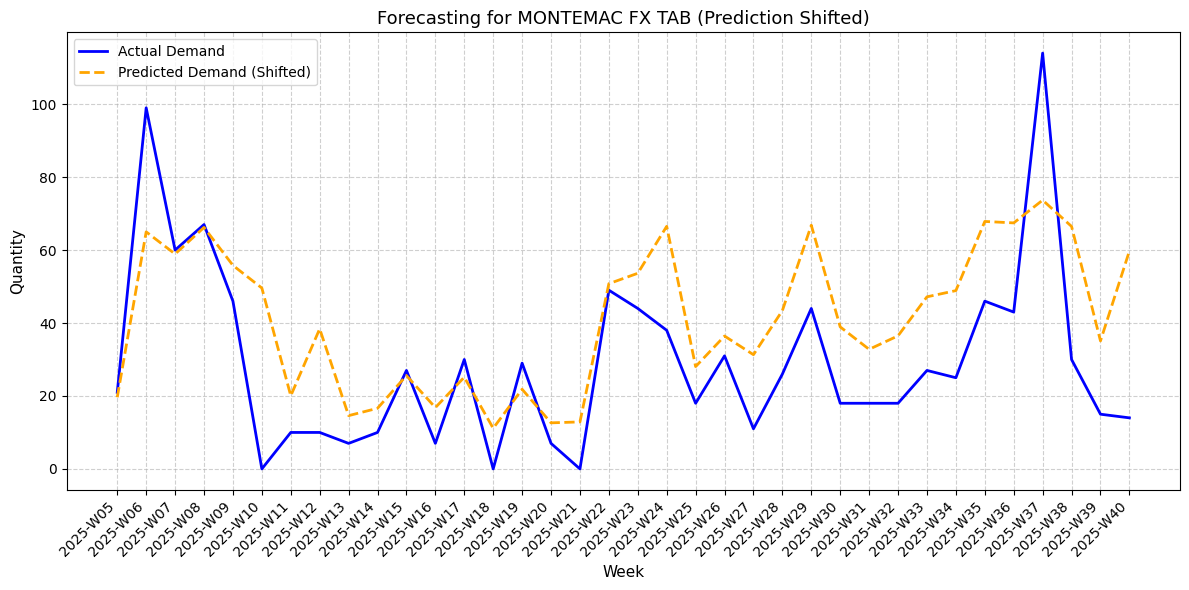

"\nplt.figure(figsize=(12, 6))\n\n# Actual Demand (full test)\nplt.plot(week_labels, y_test, color='blue', label='Actual Demand', linewidth=2)\n\n# Predicted Demand (shifted backward)\nplt.plot(shifted_weeks, shifted_pred, color='orange', linestyle='--', label='Predicted Demand (Aligned)', linewidth=2)\n\n# Labels & Title\nplt.title(f'Forecasting for {medicine_name} (Prediction Shifted)', fontsize=13)\nplt.xlabel('Week', fontsize=11)\nplt.ylabel('Quantity', fontsize=11)\n\nplt.legend()\nplt.grid(True, linestyle='--', alpha=0.6)\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n\n"

In [14]:
import matplotlib.pyplot as plt

# Number of weeks to shift prediction backward
shift_weeks = 2  # depends on your main lag features

# Week labels for test set
week_labels = df_med.loc[y_test.index, 'Week'].astype(str).values

# Shift predicted demand backward
shifted_pred = y_pred[shift_weeks:]          # drop first 'shift_weeks' predictions
shifted_weeks = week_labels[:-shift_weeks]   # drop last 'shift_weeks' weeks to align


# Align actual demand to same length as shifted predictions
aligned_y_test = y_test.iloc[:-shift_weeks]   # drop last 'shift_weeks' weeks
aligned_weeks = week_labels[:-shift_weeks]


plt.figure(figsize=(12, 6))
plt.plot(aligned_weeks, aligned_y_test.values, color='blue', label='Actual Demand', linewidth=2)
plt.plot(aligned_weeks, shifted_pred, color='orange', linestyle='--', label='Predicted Demand (Shifted)', linewidth=2)

plt.title(f'Forecasting for {medicine_name} (Prediction Shifted)', fontsize=13)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()






"""
plt.figure(figsize=(12, 6))

# Actual Demand (full test)
plt.plot(week_labels, y_test, color='blue', label='Actual Demand', linewidth=2)

# Predicted Demand (shifted backward)
plt.plot(shifted_weeks, shifted_pred, color='orange', linestyle='--', label='Predicted Demand (Aligned)', linewidth=2)

# Labels & Title
plt.title(f'Forecasting for {medicine_name} (Prediction Shifted)', fontsize=13)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

"""

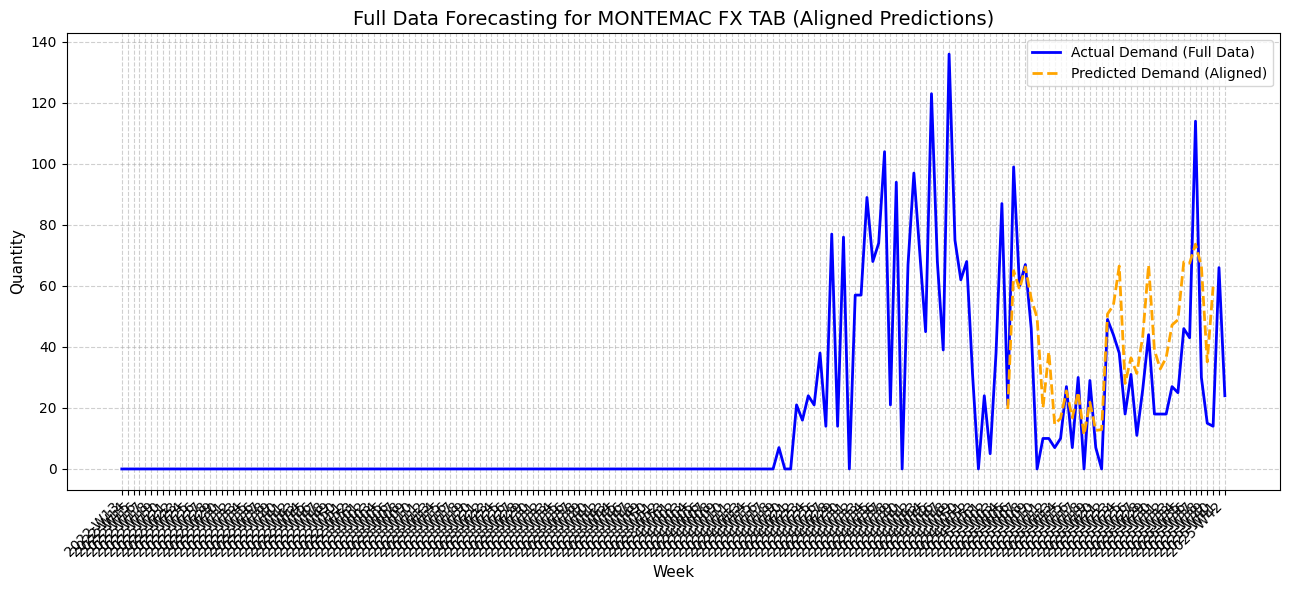

In [15]:
import matplotlib.pyplot as plt

# Number of weeks to shift prediction backward (based on dominant lags)
shift_weeks = 2  

# Prepare week labels for full data
all_weeks = df_med['Week'].astype(str).values
all_actuals = df_med['Total_Quantity'].values

# Get test week labels
test_weeks = df_med.loc[y_test.index, 'Week'].astype(str).values

# Shift predicted demand backward
shifted_pred = y_pred[shift_weeks:]              # drop first 'shift_weeks' predictions
shifted_test_weeks = test_weeks[:-shift_weeks]   # drop last 'shift_weeks' weeks to align

plt.figure(figsize=(13, 6))

# Plot full actual data (Train + Test)
plt.plot(all_weeks, all_actuals, color='blue', label='Actual Demand (Full Data)', linewidth=2)

# Plot predictions only on test weeks (shifted backward)
plt.plot(shifted_test_weeks, shifted_pred, color='orange', linestyle='--', label='Predicted Demand (Aligned)', linewidth=2)

# Labels and title
plt.title(f'Full Data Forecasting for {medicine_name} (Aligned Predictions)', fontsize=14)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)

# Legend & grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


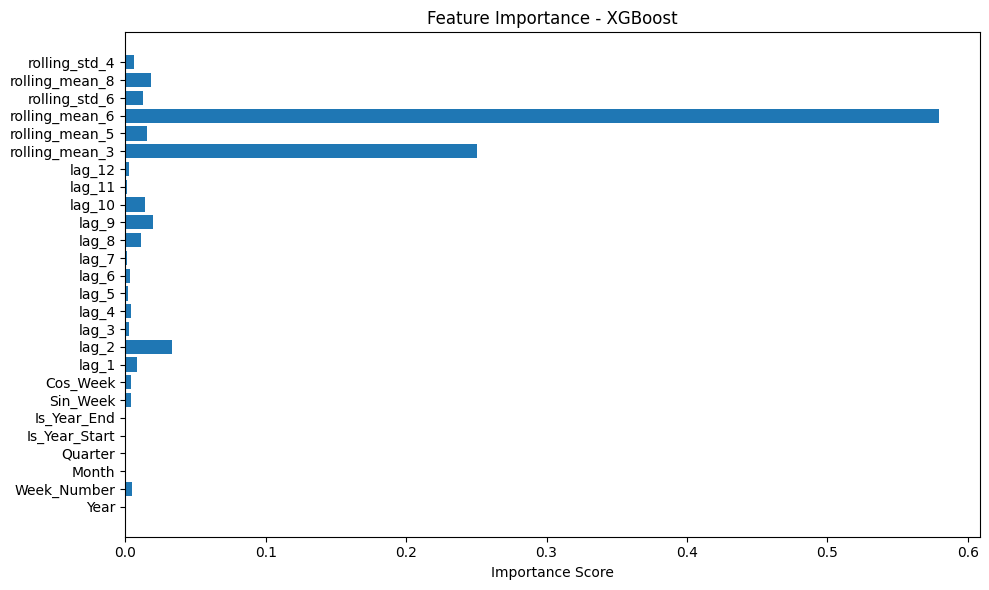

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(a.columns, model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

MODEL SAVING

In [17]:

model.save_model("../saved models/xgboost_demand_forecast.json")


RANDOMIZED SEARCH

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best Parameters Found:
{'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
🏆 Best CV MAE: 16.80

📊 Final Model Performance (Aligned by 2 Weeks):
MAE:  22.59
RMSE: 27.15
R²:   -0.17


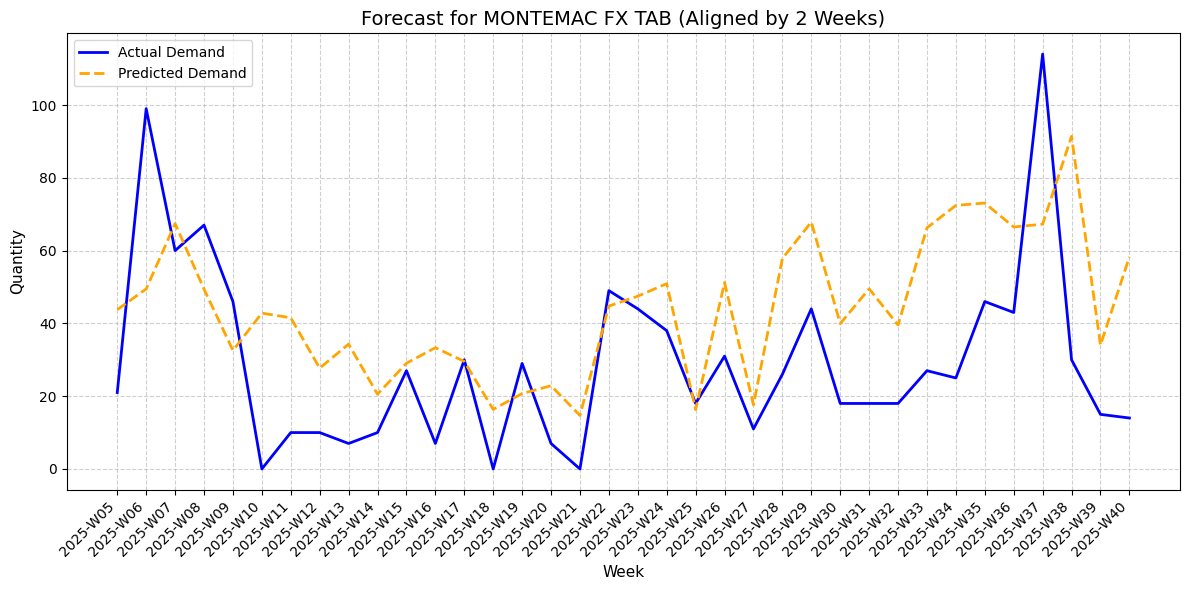

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 🔍 RandomizedSearchCV Setup
# ============================
param_grid = {
    'n_estimators': [200, 300, 400, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 8, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(search.best_params_)
print(f"🏆 Best CV MAE: {abs(search.best_score_):.2f}")

# ============================
# 🚀 Retrain with Best Params
# ============================
best_params = search.best_params_

final_xgb = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# ============================
# 📈 Predict & Align by 2 Weeks
# ============================
y_pred = final_xgb.predict(X_test)

shift_weeks = 2  # shift predicted backward (t-2)
aligned_y_pred = y_pred[shift_weeks:]
aligned_y_test = y_test[:-shift_weeks]

# ============================
# 📊 Metrics
# ============================
mae = mean_absolute_error(aligned_y_test, aligned_y_pred)
rmse = np.sqrt(mean_squared_error(aligned_y_test, aligned_y_pred))
r2 = r2_score(aligned_y_test, aligned_y_pred)

print("\n📊 Final Model Performance (Aligned by 2 Weeks):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# ============================
# 📉 Plot
# ============================
test_weeks = df_med.loc[y_test.index, 'Week'].astype(str).values
aligned_weeks = test_weeks[:-shift_weeks]

plt.figure(figsize=(12, 6))
plt.plot(aligned_weeks, aligned_y_test.values, color='blue', label='Actual Demand', linewidth=2)
plt.plot(aligned_weeks, aligned_y_pred, color='orange', linestyle='--', label='Predicted Demand', linewidth=2)

plt.title(f'Forecast for {medicine_name} (Aligned by 2 Weeks)', fontsize=14)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


MODEL PREDICTION FOR NEXT TWO MONTHS

In [ ]:
from xgboost import XGBRegressor

loaded_model = XGBRegressor()
loaded_model.load_model("../saved models/xgboost_demand_forecast.json")

print("✅ Model loaded successfully!")
